<a href="https://colab.research.google.com/github/Afsaumutoniwase/Farmsmart_model_training_and_evaluation/blob/main/Summative_Intro_to_ml_Afsa%20Umutoniwase_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo



## Optimization Techniques in Machine Learning – FarmSmart leaf health classifier

This notebook implements binary image classification for hydroponically grown plants, predicting leaf health (healthy vs unhealthy) using CNN models. The goal is to explore the impact of optimization and regularization techniques on model performance, efficiency, and convergence.



# Case Study and Implementation




In [13]:
#Import Necessary Libraries
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score


In [4]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Farmsmart_model_training_and_evaluation/Dataset_HydroFarm'
saved_models = '/content/drive/MyDrive/Farmsmart_model_training_and_evaluation/saved_models'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


In [5]:
img_size = (240, 240)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_dir + '/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_dir + '/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_dir + '/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 371 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


In [6]:
def define_model(optimizer_name='adam',
                 regularization_type=None,
                 early_stopping=False,
                 dropout=0.0,
                 learning_rate=0.001,
                 epochs=10,
                 train_data=None,
                 val_data=None,
                 model_name='model'):

    # Define regularizer
    regularizer = None
    if regularization_type == 'l1':
        regularizer = l1(0.01)
    elif regularization_type == 'l2':
        regularizer = l2(0.01)

    # Choose optimizer
    if optimizer_name.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Use 'adam' or 'rmsprop'.")

    # Build model
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(240, 240, 3), kernel_regularizer=regularizer))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizer))
    model.add(MaxPooling2D(2, 2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizer))

    if dropout > 0:
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))

    num_layers = len(model.layers)

    # Compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))

    # Train model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks
    )
    config = {
        'model_name': model_name,
        'optimizer_name': optimizer_name,
        'regularization_type': regularization_type,
        'early_stopping': early_stopping,
        'dropout': dropout,
        'learning_rate': learning_rate,
        'epochs_planned': epochs,
        'epochs_trained': len(history.history['loss']),
        'num_layers': num_layers,
        'history': history.history
    }

    return model, history, config

In [7]:
model1, history1,config1 = define_model(
    optimizer_name='adam',
    regularization_type= None,
    early_stopping=True,
    dropout=0,
    learning_rate=0.0005,
    epochs=20,
    train_data=train_gen,
    val_data=val_gen,
    model_name='model1'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5547 - loss: 0.6926 - val_accuracy: 0.5366 - val_loss: 0.6919
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5515 - loss: 0.6906 - val_accuracy: 0.5000 - val_loss: 0.6909
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4678 - loss: 0.6895 - val_accuracy: 0.5000 - val_loss: 0.6897
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5169 - loss: 0.6850 - val_accuracy: 0.5366 - val_loss: 0.6870
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5770 - loss: 0.6829 - val_accuracy: 0.5000 - val_loss: 0.6852
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5321 - loss: 0.6731 - val_accuracy: 0.5610 - val_loss: 0.6804
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5900 - loss: 0.6685 - val_accuracy: 0.5366 - val_loss: 0.6789
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6127 - loss: 0.6647 - val_accuracy: 0.5732 - val_loss:

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [8]:
def loss_curve_plot(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
def evaluate_model(model, test_gen, config=None):
  # Reset test generator to ensure proper ordering
  test_gen.reset()

  # Get predictions
  preds = model.predict(test_gen, verbose=0)
  y_pred = np.round(preds).astype(int)
  y_true = test_gen.classes

  # Calculate all metrics
  metrics = {
      'Model Name': config.get('model_name', 'unnamed_model'),
      'Optimizer': config.get('optimizer_name', 'N/A'),
      'Regularizer': config.get('regularization_type', 'None'),
      'Early Stopping': 'Yes' if config.get('early_stopping', False) else 'No',
      'Learning Rate': config.get('learning_rate', 'N/A'),
      'Epochs Planned': config.get('epochs_planned', 'N/A'),
      'Epochs Trained': config.get('epochs_trained', 'N/A'),
      'Num Layers': config.get('num_layers', 'N/A'),
      'Dropout': config.get('dropout', 0),
      'Accuracy': accuracy_score(y_true, y_pred),
      'Precision': precision_score(y_true, y_pred),
      'Recall': recall_score(y_true, y_pred),
      'F1 Score': f1_score(y_true, y_pred),
      'Training Accuracy': config.get('history', {}).get('accuracy', [None])[-1],
      'Validation Accuracy': config.get('history', {}).get('val_accuracy', [None])[-1],
      'Training Loss': config.get('history', {}).get('loss', [None])[-1],
      'Validation Loss': config.get('history', {}).get('val_loss', [None])[-1]
  }

  # Print classification report
  print(f"\n=== Evaluation Metrics for {metrics['Model Name']} ===")
  print("\nClassification Report:\n", classification_report(y_true, y_pred))
  print("\nDetailed Metrics:")
  for k, v in metrics.items():
      if isinstance(v, float):
          print(f"{k}: {v:.4f}")
      else:
          print(f"{k}: {v}")

  # Plot confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Unhealthy', 'Healthy'],
              yticklabels=['Unhealthy', 'Healthy'])
  plt.title(f"Confusion Matrix - {metrics['Model Name']}")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

  return None

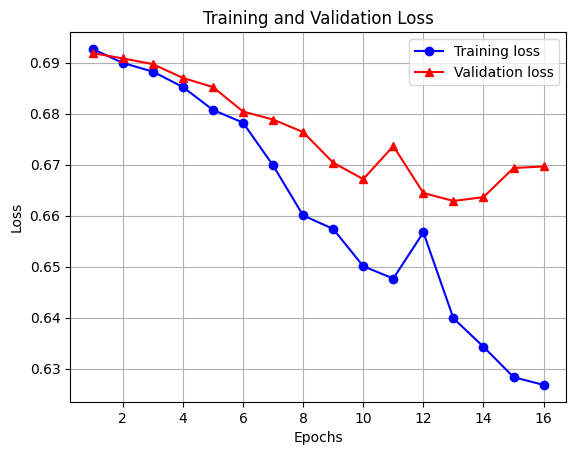

In [10]:
loss_curve_plot(history1)


=== Evaluation Metrics for model1 ===

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.66      0.75        38
           1       0.73      0.90      0.80        39

    accuracy                           0.78        77
   macro avg       0.80      0.78      0.78        77
weighted avg       0.79      0.78      0.78        77


Detailed Metrics:
Model Name: model1
Optimizer: adam
Regularizer: None
Early Stopping: Yes
Learning Rate: 0.0005
Epochs Planned: 20
Epochs Trained: 16
Num Layers: 7
Dropout: 0
Accuracy: 0.7792
Precision: 0.7292
Recall: 0.8974
F1 Score: 0.8046
Training Accuracy: 0.6146
Validation Accuracy: 0.5366
Training Loss: 0.6268
Validation Loss: 0.6697


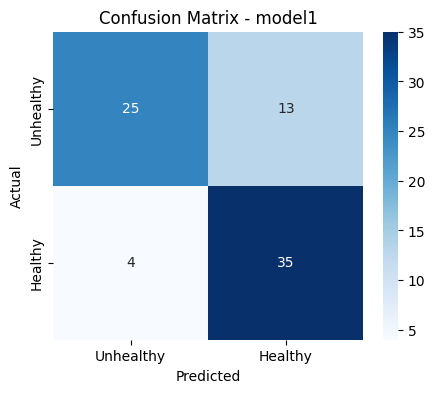

In [14]:
evaluate_model(model1, test_gen, config1)

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5240 - loss: 6.3874 - val_accuracy: 0.5000 - val_loss: 6.3228
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4924 - loss: 6.3078 - val_accuracy: 0.5000 - val_loss: 6.2414
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4696 - loss: 6.2270 - val_accuracy: 0.5000 - val_loss: 6.1612
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4977 - loss: 6.1432 - val_accuracy: 0.5000 - val_loss: 6.0822
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4897 - loss: 6.0659 - val_accuracy: 0.5000 - val_loss: 6.0041
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5473 - loss: 5.9805 - val_accuracy: 0.5000 - val_loss: 5.9266
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4672 - loss: 5.9154 - val_accuracy: 0.5000 - val_loss: 5.8497
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5196 - loss: 5.8324 - val_accuracy: 0.5000 - val_loss:

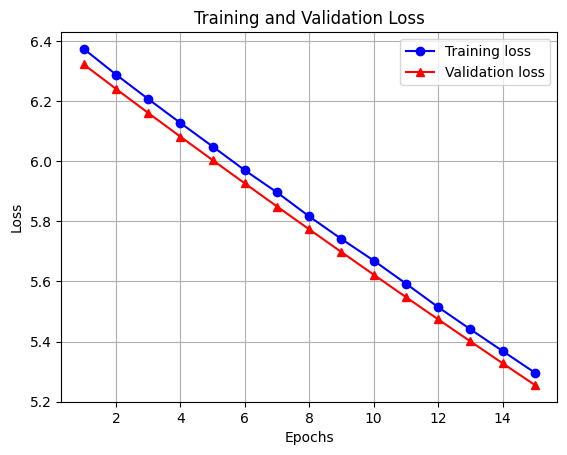


=== Evaluation Metrics for model2 ===

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.51      1.00      0.67        39

    accuracy                           0.51        77
   macro avg       0.25      0.50      0.34        77
weighted avg       0.26      0.51      0.34        77


Detailed Metrics:
Model Name: model2
Optimizer: adam
Regularizer: l1
Early Stopping: Yes
Learning Rate: 0.0001
Epochs Planned: 15
Epochs Trained: 15
Num Layers: 8
Dropout: 0.3000
Accuracy: 0.5065
Precision: 0.5065
Recall: 1.0000
F1 Score: 0.6724
Training Accuracy: 0.4528
Validation Accuracy: 0.5000
Training Loss: 5.2964
Validation Loss: 5.2554


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


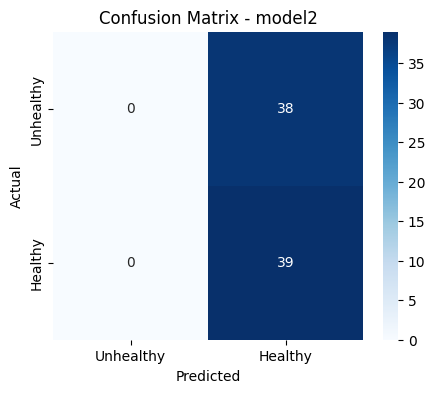

In [15]:
model2, history2, config2 = define_model(
    optimizer_name='adam',
    regularization_type= 'l1',
    early_stopping=True,
    dropout=0.3,
    learning_rate=0.0001,
    epochs=15,
    train_data=train_gen,
    val_data=val_gen,
    model_name='model2'
)

loss_curve_plot(history2)
evaluate_model(model2, test_gen, config2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5209 - loss: 1.3510 - val_accuracy: 0.5000 - val_loss: 1.2891
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5057 - loss: 1.2754 - val_accuracy: 0.5000 - val_loss: 1.2340
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5397 - loss: 1.2201 - val_accuracy: 0.5000 - val_loss: 1.1853
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5390 - loss: 1.1733 - val_accuracy: 0.5000 - val_loss: 1.1412
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5257 - loss: 1.1296 - val_accuracy: 0.5000 - val_loss: 1.0999
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5250 - loss: 1.0899 - val_accuracy: 0.5488 - val_loss: 1.0623
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5492 - loss: 1.0530 - val_accuracy: 0.5610 - val_loss: 1.0280
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5764 - loss: 1.0189 - val_accuracy: 0.5366 - val_loss:

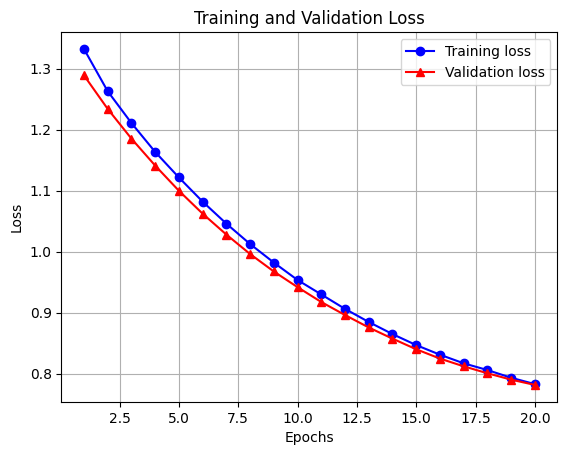


=== Evaluation Metrics for model3 ===

Classification Report:
               precision    recall  f1-score   support

           0       0.49      1.00      0.66        38
           1       0.00      0.00      0.00        39

    accuracy                           0.49        77
   macro avg       0.25      0.50      0.33        77
weighted avg       0.24      0.49      0.33        77


Detailed Metrics:
Model Name: model3
Optimizer: rmsprop
Regularizer: l2
Early Stopping: Yes
Learning Rate: 0.0005
Epochs Planned: 20
Epochs Trained: 20
Num Layers: 7
Dropout: 0
Accuracy: 0.4935
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Training Accuracy: 0.6173
Validation Accuracy: 0.5000
Training Loss: 0.7829
Validation Loss: 0.7816


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

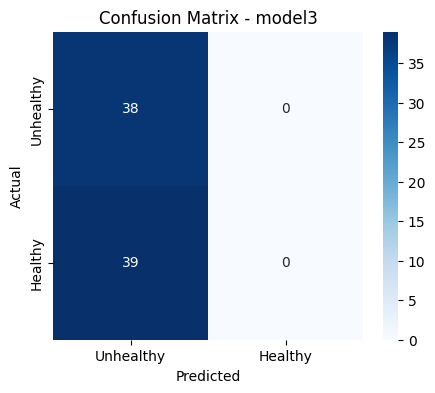

In [16]:
model3, history3, config3 = define_model(
    optimizer_name='rmsprop',
    regularization_type='l2',
    early_stopping=True,
    dropout=0,
    learning_rate=0.0005,
    epochs=20,
    train_data=train_gen,
    val_data=val_gen,
    model_name='model3'
)

loss_curve_plot(history3)
evaluate_model(model3, test_gen, config3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5063 - loss: 6.3595 - val_accuracy: 0.5000 - val_loss: 6.2690
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5232 - loss: 6.2404 - val_accuracy: 0.5000 - val_loss: 6.1805
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4800 - loss: 6.1627 - val_accuracy: 0.5000 - val_loss: 6.0978
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5119 - loss: 6.0782 - val_accuracy: 0.5000 - val_loss: 6.0171
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5056 - loss: 6.0010 - val_accuracy: 0.5000 - val_loss: 5.9379
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4804 - loss: 5.9192 - val_accuracy: 0.5000 - val_loss: 5.8592
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4916 - loss: 5.8360 - val_accuracy: 0.5000 - val_loss: 5.7809
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5076 - loss: 5.7603 - val_accuracy: 0.5000 - val_loss:

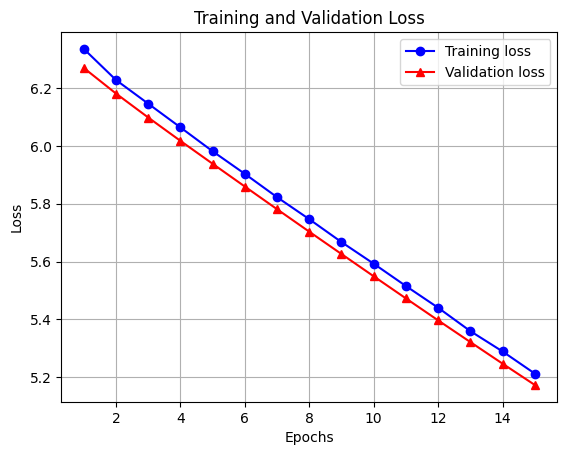


=== Evaluation Metrics for model4 ===

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.50      0.97      0.66        39

    accuracy                           0.49        77
   macro avg       0.25      0.49      0.33        77
weighted avg       0.25      0.49      0.33        77


Detailed Metrics:
Model Name: model4
Optimizer: rmsprop
Regularizer: l1
Early Stopping: Yes
Learning Rate: 0.0001
Epochs Planned: 15
Epochs Trained: 15
Num Layers: 8
Dropout: 0.5000
Accuracy: 0.4935
Precision: 0.5000
Recall: 0.9744
F1 Score: 0.6609
Training Accuracy: 0.5121
Validation Accuracy: 0.5000
Training Loss: 5.2130
Validation Loss: 5.1737


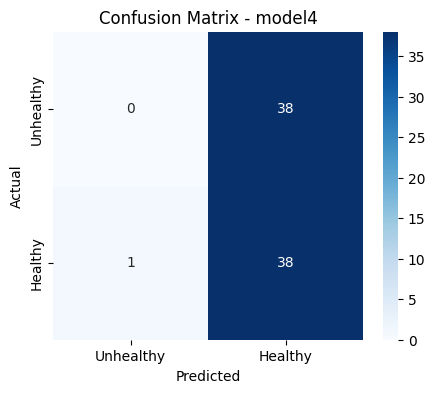

In [17]:
model4, history4, config4 = define_model(
    optimizer_name='rmsprop',
    regularization_type='l1',
    early_stopping=True,
    dropout=0.5,
    learning_rate=0.0001,
    epochs=15,
    train_data=train_gen,
    val_data=val_gen,
    model_name='model4'
)

loss_curve_plot(history4)
evaluate_model(model4, test_gen, config4)

Found 371 images belonging to 2 classes.
Found 77 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 236s 19s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 15s/step

Accuracy: 0.9610 | F1-Score: 0.9620

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        38
           1       0.95      0.97      0.96        39

    accuracy                           0.96        77
   macro avg       0.96      0.96      0.96        77
weighted avg       0.96      0.96      0.96        77



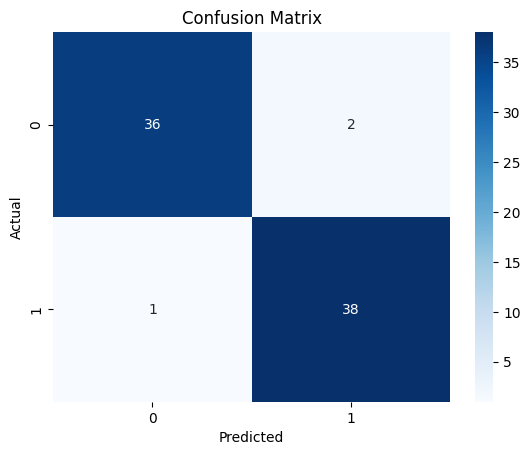

Model saved as 'saved_models/model5_vgg16.h5'


In [18]:
def define_model5(data_dir='data',
                  img_size=(240, 240),
                  batch_size=32,
                  max_iter=1000,
                  C=1.0,
                  solver='liblinear',
                  model_path='saved_models/model5_vgg16.h5'):
    # Data Preparation
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen = datagen.flow_from_directory(
        data_dir + '/train',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    test_gen = datagen.flow_from_directory(
        data_dir + '/test',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Feature Extraction using VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,))
    feature_model = Model(inputs=base_model.input, outputs=base_model.output)

    def extract_features(generator):
        features = feature_model.predict(generator, verbose=1)
        features_flattened = features.reshape(features.shape[0], -1)
        labels = generator.classes
        return features_flattened, labels

    X_train, y_train = extract_features(train_gen)
    X_test, y_test = extract_features(test_gen)

    # Train Logistic Regression
    clf = LogisticRegression(max_iter=max_iter, C=C, solver=solver)
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\nAccuracy: {acc:.4f} | F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", report)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save model
    joblib.dump(clf, model_path)
    print(f"Model saved as '{model_path}'")

    # Return model and metrics
    return clf, {
        'accuracy': acc,
        'f1_score': f1,
        'report': report,
        'confusion_matrix': cm
    }
model5, metrics5 = define_model5(data_dir=data_dir)

In [19]:
model1.save('saved_models/model1_baseline.h5', include_optimizer=False)
model2.save('saved_models/model2_adam&dropout.h5', include_optimizer=False)
model3.save('saved_models/model3_rmsprop&l2.h5', include_optimizer=False)
model4.save('saved_models/model4_rmsprop&l1.h5', include_optimizer=False)

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [22]:
def save_best_model(model, base_path='saved_models/best_model'):
    if isinstance(model, Model):
        save_path = base_path + '.h5'
        model.save(save_path)
        print(f"Keras model saved as '{save_path}'")
    else:
        save_path = base_path + '.pkl'
        joblib.dump(model, save_path)
        print(f"Sklearn model saved as '{save_path}'")
    return save_path

img_size = (240, 240)
batch_size = 32
base_save_path = 'saved_models/best_model'

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

model_paths = {
    'model1': 'saved_models/model1_baseline.h5',
    'model2': 'saved_models/model2_adam&dropout.h5',
    'model3': 'saved_models/model3_rmsprop&l2.h5',
    'model4': 'saved_models/model4_rmsprop&l1.h5',
}

keras_models = {name: load_model(path) for name, path in model_paths.items()}

logistic_model = joblib.load('saved_models/model5_vgg16.h5')

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
feature_extractor = Model(inputs=vgg.input, outputs=vgg.output)

def extract_features(generator):
    features = feature_extractor.predict(generator, verbose=0)
    features = features.reshape(features.shape[0], -1)
    return features, generator.classes

results = {}

for name, model in keras_models.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # <- Recompile
    loss, acc = model.evaluate(test_gen, verbose=0)
    results[name] = (acc, model)

X_test, y_test = extract_features(test_gen)
y_pred = logistic_model.predict(X_test)
log_acc = accuracy_score(y_test, y_pred)
results['model5'] = (log_acc, logistic_model)

best_model_name = max(results, key=lambda k: results[k][0])
best_accuracy, best_model = results[best_model_name]
save_best_model(best_model, base_path=base_save_path)

print(f"{best_model_name} is the best model with accuracy = {best_accuracy:.4f}")


Found 77 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Sklearn model saved as 'saved_models/best_model.pkl'
model5 is the best model with accuracy = 0.9610


In [23]:
def make_predictions(base_model_path, test_gen, threshold=0.5):
    h5_path = base_model_path + '.h5'
    pkl_path = base_model_path + '.pkl'

    if os.path.exists(h5_path):
        try:
            model = load_model(h5_path)
            probs = model.predict(test_gen, verbose=0)
            preds = (probs > threshold).astype(int)
            print("Predictions made using Keras model.")
        except Exception as e:
            print("Failed to use Keras model. Error:", e)
            model = joblib.load(pkl_path)
            X_test, _ = extract_features(test_gen)
            probs = model.predict_proba(X_test)[:, 1]
            preds = (probs > threshold).astype(int)
            print("Fallback to Logistic Regression model.")
    elif os.path.exists(pkl_path):
        model = joblib.load(pkl_path)
        X_test, _ = extract_features(test_gen)
        probs = model.predict_proba(X_test)[:, 1]
        preds = (probs > threshold).astype(int)
        print("Predictions made using Logistic Regression model.")
    else:
        raise FileNotFoundError("No saved model found at given path with either .h5 or .pkl extension.")

    return preds
base_model_path = 'saved_models/best_model'
preds = make_predictions(base_model_path, test_gen, threshold=0.5)

test_labels = test_gen.classes
print("Unhealthy:", sum(test_labels == 0), "Healthy:", sum(test_labels == 1))
print("Sample Predictions:", preds[:20])


Predictions made using Logistic Regression model.
Unhealthy: 38 Healthy: 39
Sample Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Congratulations!!
